In [147]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [148]:
# Charger le fichier CSV en dataframe
df_travaux = pd.read_csv("data_travaux/travaux-engages-metropole-lyon.csv", sep=";")
display(df_travaux)

,numero,intervenant,nature_chantier,nature_travaux,etat,date_debut,date_fin,mesures_police,last_update,adresse,commune,code_insee,contact_tel,contact_mail,contact_url,gid
0,202206858,LYON - Direction De La Construction,Travaux sur une parcelle en limite d'espace pu...,Renfort chaussée en vue de la pose d'une grue,Ouvert,2024-06-03,2028-12-31,NaN,2025-02-07 09:02:15.051362+01:00,"10 rue Neyret, 69001 Rue des Tables Claudienn...",Lyon 1er,69381,NaN,NaN,NaN,183025
1,202512731,ORANGE SA,"Branchements réseau < 25 ml TELECOM, RMT ET VIDEO","Intervention sur des chambres, boites, armoire...",Validé,2025-12-24,2026-01-07,"Circulation alternée, Restriction de jour",2025-12-16 15:02:03.127680+01:00,Face au 10 Route du Bruissin (Francheville),Francheville,69089,NaN,NaN,NaN,199942
2,202512882,DCE / RT / Rive Gauche,Émergences et autres équipements d'assainissement,Remise à niveau / entretien des tampons et éme...,Validé,2025-12-15,2026-01-16,NaN,2025-12-04 12:02:37.539147+01:00,"Avenue d'Oschatz, de Rue Gaston Monmousseau a...",Venissieux,69259,04 28 67 55 00,NaN,NaN,199946
3,202512887,ORANGE SA,"Branchements réseau < 25 ml TELECOM, RMT ET VIDEO",Réparation de branchement < 25 ml (télécom ou ...,Validé,2025-12-12,2026-01-19,NaN,2025-12-04 12:02:38.122193+01:00,à côté 3 Chemin de Chantegrillet (Francheville),Francheville,69089,NaN,NaN,NaN,199947
4,202513013,DCE / RT / Rive Droite Sud,"Construction, renouvellement et réparation rés...",Réparation de canalisation d'assainissement,Validé,2025-12-08,2025-12-19,NaN,2025-12-04 12:02:38.969904+01:00,35 Rue Pierre Dupont (Lyon 1er Arrondissement),Lyon 1er,69381,04 28 67 55 20,NaN,NaN,199954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,202512873,RCU Centre Métropole - ELM (Dalkia),"Construction, renouvellement et réparation rés...",Construction de réseau sans branchement (Chauf...,Validé,2025-12-02,2025-12-24,NaN,2025-12-16 15:02:03.235650+01:00,"Du 16 Rue du 8 Mai 1945, au 104 Place du 8 Mai...",Saint Priest,69290,NaN,NaN,NaN,199822
1315,202301053,AOMTL (SYTRAL Mobilités),Aménagement pour les transports en commun,Création / aménagement de voie Bus / Tram,Ouvert,2023-02-07,2026-08-31,NaN,2023-02-07 18:07:40.672980+01:00,- Rue Rue Florian (Villeurbanne) : De Avenue A...,Villeurbanne,69266,NaN,NaN,NaN,135907
1316,202301060,AOMTL (SYTRAL Mobilités),Aménagement pour les transports en commun,Création / aménagement de voie Bus / Tram,Ouvert,2023-01-23,2026-08-31,NaN,2023-02-07 18:07:10.246549+01:00,Tracé T6N du carrefour Zola/Verlaine Bourgey a...,Villeurbanne,69266,NaN,NaN,NaN,135939
1317,202301064,AOMTL (SYTRAL Mobilités),Aménagement pour les transports en commun,Création / aménagement de voie Bus / Tram,Ouvert,2023-01-23,2026-08-31,NaN,2023-02-07 18:07:31.539607+01:00,Traversée futur Parc - Usine ACI Villeurbanne ...,Villeurbanne,69266,NaN,NaN,NaN,135921


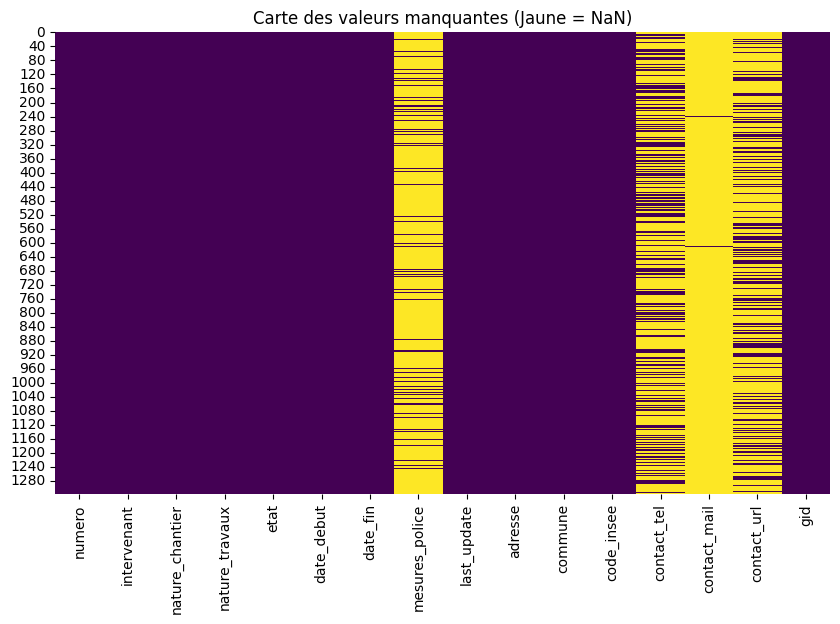

In [149]:
# création de la map
plt.figure(figsize=(10, 6))
# isnull() transforme les données en True (vide) / False (plein)
sns.heatmap(df_travaux.isnull(), cbar=False, cmap='viridis') 
plt.title("Carte des valeurs manquantes (Jaune = NaN)")
plt.show()



In [150]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['mesures_police', 'contact_tel', 'contact_mail', 'contact_url']

# On supprime (errors='ignore' évite un crash si une colonne n'existe pas déjà)
df_travaux = df_travaux.drop(columns=colonnes_a_supprimer, errors='ignore')

# Filtrer les lignes où 'date_debut' est vide (NaN)
df_travaux = df_travaux.dropna(subset=['date_debut'])


In [151]:
# Charger le fichier CSV en dataframe
df_flux = pd.read_csv("data_flux/mesures-comptage-metropole-lyon.csv", sep=";")
print(df_flux.describe())
display(df_flux.head(15))





         channel_id        count
count  1.000000e+03  1000.000000
mean   1.001906e+08    35.872000
std    3.596634e+05    50.602512
min    1.000298e+08     0.000000
25%    1.000344e+08     3.000000
50%    1.000344e+08    16.000000
75%    1.000349e+08    51.000000
max    1.010178e+08   333.000000


,channel_id,counter_id,start_datetime,end_datetime,count
0,100029813,NaN,2023-04-06 01:00:00+02:00,2023-04-06 02:00:00+02:00,0
1,100029813,NaN,2023-04-06 00:00:00+02:00,2023-04-06 01:00:00+02:00,0
2,100029813,NaN,2023-04-05 23:00:00+02:00,2023-04-06 00:00:00+02:00,0
3,100029813,NaN,2023-04-05 22:00:00+02:00,2023-04-05 23:00:00+02:00,1
4,100029813,NaN,2023-04-05 21:00:00+02:00,2023-04-05 22:00:00+02:00,0
5,100029813,NaN,2023-04-05 20:00:00+02:00,2023-04-05 21:00:00+02:00,6
6,100029813,NaN,2023-04-05 19:00:00+02:00,2023-04-05 20:00:00+02:00,37
7,100029813,NaN,2023-04-05 18:00:00+02:00,2023-04-05 19:00:00+02:00,80
8,100029813,NaN,2023-04-05 17:00:00+02:00,2023-04-05 18:00:00+02:00,90
9,100029813,NaN,2023-04-05 16:00:00+02:00,2023-04-05 17:00:00+02:00,71


In [152]:
# Filtrer pour garder uniquement les lignes où 'counter_id' est présent
lignes_avec_compteur = df_flux[df_flux['counter_id'].notna()]

# Afficher le résultat
lignes_avec_compteur

,channel_id,counter_id,start_datetime,end_datetime,count
840,101013842,X2G14055672,2023-04-06 01:00:00+02:00,2023-04-06 02:00:00+02:00,2
841,101013842,X2G14055672,2023-04-06 00:00:00+02:00,2023-04-06 01:00:00+02:00,6
842,101013842,X2G14055672,2023-04-05 23:00:00+02:00,2023-04-06 00:00:00+02:00,21
843,101013842,X2G14055672,2023-04-05 22:00:00+02:00,2023-04-05 23:00:00+02:00,18
844,101013842,X2G14055672,2023-04-05 21:00:00+02:00,2023-04-05 22:00:00+02:00,28
...,...,...,...,...,...
995,101017787,X2H14116816,2023-04-05 14:00:00+02:00,2023-04-05 15:00:00+02:00,1
996,101017787,X2H14116816,2023-04-05 13:00:00+02:00,2023-04-05 14:00:00+02:00,1
997,101017787,X2H14116816,2023-04-05 12:00:00+02:00,2023-04-05 13:00:00+02:00,1
998,101017787,X2H14116816,2023-04-05 11:00:00+02:00,2023-04-05 12:00:00+02:00,0


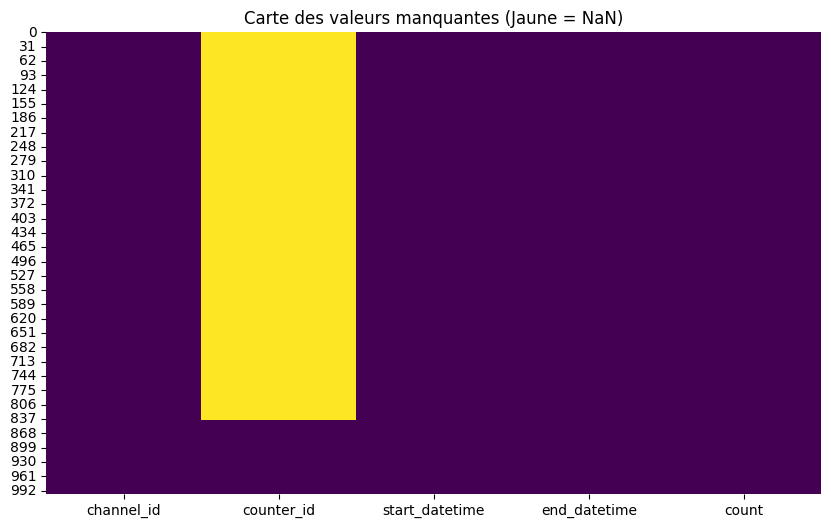

In [153]:
# création de la map
plt.figure(figsize=(10, 6))
# isnull() transforme les données en True (vide) / False (plein)
sns.heatmap(df_flux.isnull(), cbar=False, cmap='viridis') 
plt.title("Carte des valeurs manquantes (Jaune = NaN)")
plt.show()

In [154]:
df_flux = df_flux.drop(columns='counter_id', errors='ignore')
df_flux

,channel_id,start_datetime,end_datetime,count
0,100029813,2023-04-06 01:00:00+02:00,2023-04-06 02:00:00+02:00,0
1,100029813,2023-04-06 00:00:00+02:00,2023-04-06 01:00:00+02:00,0
2,100029813,2023-04-05 23:00:00+02:00,2023-04-06 00:00:00+02:00,0
3,100029813,2023-04-05 22:00:00+02:00,2023-04-05 23:00:00+02:00,1
4,100029813,2023-04-05 21:00:00+02:00,2023-04-05 22:00:00+02:00,0
...,...,...,...,...
995,101017787,2023-04-05 14:00:00+02:00,2023-04-05 15:00:00+02:00,1
996,101017787,2023-04-05 13:00:00+02:00,2023-04-05 14:00:00+02:00,1
997,101017787,2023-04-05 12:00:00+02:00,2023-04-05 13:00:00+02:00,1
998,101017787,2023-04-05 11:00:00+02:00,2023-04-05 12:00:00+02:00,0


In [155]:
# Charger le geojson des problèmes reportés (clusters rouges)
gdf_rouges = gpd.read_file("data_coord/clusters-rouges-200046977.geojson")
print(gdf_rouges.head())


                                    uid  insee  cat  nb_points taux_points  \
0  1928af76-3a27-4bb5-82bb-008f4b9b3e86  69199   58         24       64.86   
1  1eca17ef-9918-4bf9-8538-6483192bcd51  69266   58        179        8.69   
2  0b7b0a92-d58f-4977-a3eb-8a3fee9c15ba  69266   58        286       13.88   
3  7344fd97-e04c-4f58-94e1-3f9be8129a90  69388   58         78       17.45   
4  04b1ae46-0b6b-4e2f-b5a5-b97055ce0b37  69081   58        228      131.79   

                                            geometry  
0  MULTIPOLYGON (((4.85501 45.71655, 4.85466 45.7...  
1  MULTIPOLYGON (((4.90377 45.7671, 4.90383 45.76...  
2  MULTIPOLYGON (((4.88687 45.76772, 4.8832 45.76...  
3  MULTIPOLYGON (((4.86138 45.74896, 4.86035 45.7...  
4  MULTIPOLYGON (((4.7907 45.77199, 4.78997 45.77...  
